<a href="https://colab.research.google.com/github/eduion/computer_vision/blob/main/food_image_recognition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!wget http://data.vision.ee.ethz.ch/cvl/food-101.tar.gz
!tar xzvf food-101.tar.gz

串流輸出內容已截斷至最後 5000 行。
food-101/images/cannoli/695879.jpg
food-101/images/cannoli/1767088.jpg
food-101/images/cannoli/3201965.jpg
food-101/images/cannoli/3778102.jpg
food-101/images/cannoli/2674065.jpg
food-101/images/cannoli/1169899.jpg
food-101/images/cannoli/1378086.jpg
food-101/images/cannoli/803909.jpg
food-101/images/cannoli/1067240.jpg
food-101/images/cannoli/3002709.jpg
food-101/images/cannoli/2612632.jpg
food-101/images/cannoli/3627612.jpg
food-101/images/cannoli/1798703.jpg
food-101/images/cannoli/560632.jpg
food-101/images/cannoli/512468.jpg
food-101/images/cannoli/2331523.jpg
food-101/images/cannoli/3118302.jpg
food-101/images/cannoli/1499412.jpg
food-101/images/cannoli/1557459.jpg
food-101/images/cannoli/146566.jpg
food-101/images/cannoli/96922.jpg
food-101/images/cannoli/1699562.jpg
food-101/images/cannoli/730051.jpg
food-101/images/cannoli/2177977.jpg
food-101/images/cannoli/2767028.jpg
food-101/images/cannoli/6564.jpg
food-101/images/cannoli/553447.jpg
food-101/images/can

In [ ]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator

DATA_DIR = "/content/food-101"
IMG_DIR  = os.path.join(DATA_DIR, "images")
META_DIR = os.path.join(DATA_DIR, "meta")

print("DATA_DIR:", DATA_DIR)
print("IMG_DIR :", IMG_DIR)
print("META_DIR:", META_DIR)

%matplotlib inline

DATA_DIR: /content/food-101
IMG_DIR : /content/food-101/images
META_DIR: /content/food-101/meta


In [ ]:
def load_split_list(split_txt):
    """從 meta/train.txt 或 meta/test.txt 讀出完整圖片路徑與類別名稱"""
    paths = []
    labels = []
    split_path = os.path.join(META_DIR, split_txt)
    with open(split_path, "r") as f:
        lines = [line.strip() for line in f.readlines()]
        for line in lines:
            cls, img_id = line.split('/')
            img_path = os.path.join(IMG_DIR, cls, img_id + ".jpg")
            paths.append(img_path)
            labels.append(cls)              # 類別名稱就是資料夾名稱
    return paths, labels

train_paths_all, train_labels_all = load_split_list("train.txt")
test_paths, test_labels = load_split_list("test.txt")

print(f"train.txt 圖片數量 : {len(train_paths_all)}")
print(f"test.txt  圖片數量 : {len(test_paths)}")
train_paths, val_paths, train_labels, val_labels = train_test_split(
    train_paths_all,
    train_labels_all,
    test_size=0.2,              # 從官方 train 裡切 20% 出來當 val
    stratify=train_labels_all,  # 照類別比例切，避免不平衡
    random_state=42
)

print(f"實際使用的 train 數量 : {len(train_paths)}")
print(f"實際使用的 val   數量 : {len(val_paths)}")
print(f"實際使用的 test  數量 : {len(test_paths)}")

train.txt 圖片數量 : 75750
test.txt  圖片數量 : 25250
實際使用的 train 數量 : 60600
實際使用的 val   數量 : 15150
實際使用的 test  數量 : 25250


In [ ]:
df_train = pd.DataFrame({"filepath": train_paths, "label": train_labels})
df_val   = pd.DataFrame({"filepath": val_paths,   "label": val_labels})
df_test  = pd.DataFrame({"filepath": test_paths,  "label": test_labels})

print(df_train.head())


                                            filepath         label
0      /content/food-101/images/prime_rib/940686.jpg     prime_rib
1      /content/food-101/images/hamburger/110991.jpg     hamburger
2  /content/food-101/images/beef_tartare/1837012.jpg  beef_tartare
3       /content/food-101/images/oysters/3110396.jpg       oysters
4       /content/food-101/images/churros/1721260.jpg       churros


In [ ]:
IMG_SIZE   = 224   # MobileNetV2 輸入大小
BATCH_SIZE = 32

# 訓練集：正常化 + 資料增強
train_datagen = ImageDataGenerator(
    rescale=1.0/255,        # 像素值縮放到 [0,1]
    rotation_range=10,      # 隨機旋轉 ±10°
    width_shift_range=0.1,  # 水平平移
    height_shift_range=0.1, # 垂直平移
    horizontal_flip=True    # 左右翻轉
)

# 驗證與測試：只做 rescale，不做增強
test_datagen = ImageDataGenerator(
    rescale=1.0/255
)

train_gen = train_datagen.flow_from_dataframe(
    df_train,
    x_col="filepath",
    y_col="label",
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode="categorical",   # 自動轉 one-hot
    shuffle=True
)

val_gen = test_datagen.flow_from_dataframe(
    df_val,
    x_col="filepath",
    y_col="label",
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    shuffle=False
)

test_gen = test_datagen.flow_from_dataframe(
    df_test,
    x_col="filepath",
    y_col="label",
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    shuffle=False
)

print("train_gen.samples :", train_gen.samples)
print("val_gen.samples   :", val_gen.samples)
print("test_gen.samples  :", test_gen.samples)
print("class_indices     :", train_gen.class_indices)


Found 60600 validated image filenames belonging to 101 classes.
Found 15150 validated image filenames belonging to 101 classes.
Found 25250 validated image filenames belonging to 101 classes.
train_gen.samples : 60600
val_gen.samples   : 15150
test_gen.samples  : 25250
class_indices     : {'apple_pie': 0, 'baby_back_ribs': 1, 'baklava': 2, 'beef_carpaccio': 3, 'beef_tartare': 4, 'beet_salad': 5, 'beignets': 6, 'bibimbap': 7, 'bread_pudding': 8, 'breakfast_burrito': 9, 'bruschetta': 10, 'caesar_salad': 11, 'cannoli': 12, 'caprese_salad': 13, 'carrot_cake': 14, 'ceviche': 15, 'cheese_plate': 16, 'cheesecake': 17, 'chicken_curry': 18, 'chicken_quesadilla': 19, 'chicken_wings': 20, 'chocolate_cake': 21, 'chocolate_mousse': 22, 'churros': 23, 'clam_chowder': 24, 'club_sandwich': 25, 'crab_cakes': 26, 'creme_brulee': 27, 'croque_madame': 28, 'cup_cakes': 29, 'deviled_eggs': 30, 'donuts': 31, 'dumplings': 32, 'edamame': 33, 'eggs_benedict': 34, 'escargots': 35, 'falafel': 36, 'filet_mignon': 

In [ ]:
import tensorflow as tf
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

num_classes = df_train["label"].nunique()
print("num_classes =", num_classes)

# =========================
# 1. 建立 MobileNetV2 backbone（預訓練，去掉原本的分類頭）
# =========================
base_model = MobileNetV2(
    input_shape=(IMG_SIZE, IMG_SIZE, 3),
    include_top=False,      # 不要原本 ImageNet 的 1000 類 head
    weights="imagenet"      # 使用 ImageNet 預訓練權重
)

# =========================
# 2. 決定要微調多少層：只開後面幾層來訓練
# =========================
# 例如解凍最後 30 層，其餘凍結
fine_tune_at = 30

# 先全部凍結
for layer in base_model.layers:
    layer.trainable = False

# 再把最後 fine_tune_at 層打開
for layer in base_model.layers[-fine_tune_at:]:
    layer.trainable = True

print("Total layers in base_model:", len(base_model.layers))
print("Trainable layers in base_model (last {}):".format(fine_tune_at))
# for layer in base_model.layers[-fine_tune_at:]:
#     print(layer.name, "trainable =", layer.trainable)

# =========================
# 3. 接上自己的分類 head
# =========================
x = GlobalAveragePooling2D()(base_model.output)
x = Dense(256, activation="relu")(x)
x = Dropout(0.5)(x)                      # Dropout 防 overfitting
output = Dense(num_classes, activation="softmax")(x)     # 101 類輸出

model = Model(inputs=base_model.input, outputs=output)


# =========================
# 4. 編譯模型
# =========================
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

# =========================
# 5. Callbacks（存最佳模型 + 提早停止）
# =========================
checkpoint_cb = ModelCheckpoint(
    "mobilenetv2_food101_finetune_best.h5",
    monitor="val_accuracy",
    save_best_only=True,
    mode="max",
    verbose=1
)

earlystop_cb = EarlyStopping(
    monitor="val_loss",
    patience=3,              # 連續 3 個 epoch 沒進步就停
    restore_best_weights=True,
    verbose=1
)

# =========================
# 6. 訓練(fintune)
# =========================
EPOCHS = 10

history = model.fit(
    train_gen,
    epochs=EPOCHS,
    validation_data=val_gen,
    callbacks=[checkpoint_cb, earlystop_cb]
)

# =========================
# 7. 在 Test set 上做最終評估
# =========================
test_loss, test_acc = model.evaluate(test_gen)
print("Fine-tune - Test loss :", test_loss)
print("Fine-tune - Test acc  :", test_acc)

# =========================
# 8. 儲存模型
# =========================
model.save("mobilenetv2_food101_finetune_allinone.h5")
print("模型已儲存為 mobilenetv2_food101_finetune_allinone.h5")


num_classes = 101
Total layers in base_model: 154
Trainable layers in base_model (last 30):
Epoch 1/10
1894/1894 ━━━━━━━━━━━━━━━━━━━━ 0s 421ms/step - accuracy: 0.1742 - loss: 3.7688
Epoch 1: val_accuracy improved from -inf to 0.51591, saving model to mobilenetv2_food101_finetune_best.h5


1894/1894 ━━━━━━━━━━━━━━━━━━━━ 873s 453ms/step - accuracy: 0.1742 - loss: 3.7685 - val_accuracy: 0.5159 - val_loss: 1.9329
Epoch 2/10
1894/1894 ━━━━━━━━━━━━━━━━━━━━ 0s 403ms/step - accuracy: 0.4755 - loss: 2.1646
Epoch 2: val_accuracy improved from 0.51591 to 0.57875, saving model to mobilenetv2_food101_finetune_best.h5


1894/1894 ━━━━━━━━━━━━━━━━━━━━ 801s 423ms/step - accuracy: 0.4756 - loss: 2.1646 - val_accuracy: 0.5787 - val_loss: 1.6529
Epoch 3/10
1894/1894 ━━━━━━━━━━━━━━━━━━━━ 0s 391ms/step - accuracy: 0.5569 - loss: 1.7868
Epoch 3: val_accuracy improved from 0.57875 to 0.60911, saving model to mobilenetv2_food101_finetune_best.h5


1894/1894 ━━━━━━━━━━━━━━━━━━━━ 778s 411ms/step - accuracy: 0.5569 - loss: 1.7868 - val_accuracy: 0.6091 - val_loss: 1.5517
Epoch 4/10
1894/1894 ━━━━━━━━━━━━━━━━━━━━ 0s 392ms/step - accuracy: 0.6010 - loss: 1.5755
Epoch 4: val_accuracy improved from 0.60911 to 0.63056, saving model to mobilenetv2_food101_finetune_best.h5


1894/1894 ━━━━━━━━━━━━━━━━━━━━ 779s 411ms/step - accuracy: 0.6010 - loss: 1.5755 - val_accuracy: 0.6306 - val_loss: 1.4612
Epoch 5/10
1894/1894 ━━━━━━━━━━━━━━━━━━━━ 0s 388ms/step - accuracy: 0.6334 - loss: 1.4301
Epoch 5: val_accuracy improved from 0.63056 to 0.64251, saving model to mobilenetv2_food101_finetune_best.h5


1894/1894 ━━━━━━━━━━━━━━━━━━━━ 771s 407ms/step - accuracy: 0.6334 - loss: 1.4301 - val_accuracy: 0.6425 - val_loss: 1.4273
Epoch 6/10
1894/1894 ━━━━━━━━━━━━━━━━━━━━ 0s 390ms/step - accuracy: 0.6614 - loss: 1.3040
Epoch 6: val_accuracy improved from 0.64251 to 0.64898, saving model to mobilenetv2_food101_finetune_best.h5


1894/1894 ━━━━━━━━━━━━━━━━━━━━ 778s 411ms/step - accuracy: 0.6614 - loss: 1.3040 - val_accuracy: 0.6490 - val_loss: 1.4050
Epoch 7/10
1894/1894 ━━━━━━━━━━━━━━━━━━━━ 0s 393ms/step - accuracy: 0.6844 - loss: 1.1997
Epoch 7: val_accuracy did not improve from 0.64898
1894/1894 ━━━━━━━━━━━━━━━━━━━━ 782s 413ms/step - accuracy: 0.6844 - loss: 1.1998 - val_accuracy: 0.6454 - val_loss: 1.4216
Epoch 8/10
1894/1894 ━━━━━━━━━━━━━━━━━━━━ 0s 389ms/step - accuracy: 0.7061 - loss: 1.1006
Epoch 8: val_accuracy improved from 0.64898 to 0.65426, saving model to mobilenetv2_food101_finetune_best.h5


1894/1894 ━━━━━━━━━━━━━━━━━━━━ 774s 409ms/step - accuracy: 0.7061 - loss: 1.1006 - val_accuracy: 0.6543 - val_loss: 1.3954
Epoch 9/10
1894/1894 ━━━━━━━━━━━━━━━━━━━━ 0s 391ms/step - accuracy: 0.7276 - loss: 1.0206
Epoch 9: val_accuracy improved from 0.65426 to 0.65723, saving model to mobilenetv2_food101_finetune_best.h5


1894/1894 ━━━━━━━━━━━━━━━━━━━━ 785s 414ms/step - accuracy: 0.7276 - loss: 1.0206 - val_accuracy: 0.6572 - val_loss: 1.3968
Epoch 10/10
1894/1894 ━━━━━━━━━━━━━━━━━━━━ 0s 391ms/step - accuracy: 0.7417 - loss: 0.9636
Epoch 10: val_accuracy did not improve from 0.65723
1894/1894 ━━━━━━━━━━━━━━━━━━━━ 778s 411ms/step - accuracy: 0.7417 - loss: 0.9636 - val_accuracy: 0.6453 - val_loss: 1.4407
Restoring model weights from the end of the best epoch: 8.
790/790 ━━━━━━━━━━━━━━━━━━━━ 92s 116ms/step - accuracy: 0.6876 - loss: 1.1817


Fine-tune - Test loss : 1.1077696084976196
Fine-tune - Test acc  : 0.7072474956512451
模型已儲存為 mobilenetv2_food101_finetune_allinone.h5


dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])


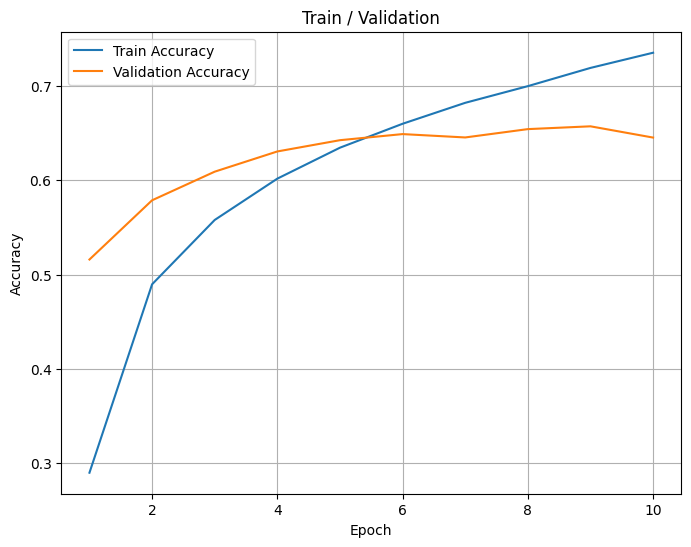

In [ ]:
print(history.history.keys())
import matplotlib.pyplot as plt

acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]
epochs = range(1, len(acc) + 1)

plt.figure(figsize=(8, 6))
plt.plot(epochs, acc, label="Train Accuracy")
plt.plot(epochs, val_acc, label="Validation Accuracy")

plt.title("Train / Validation")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True)
plt.show()



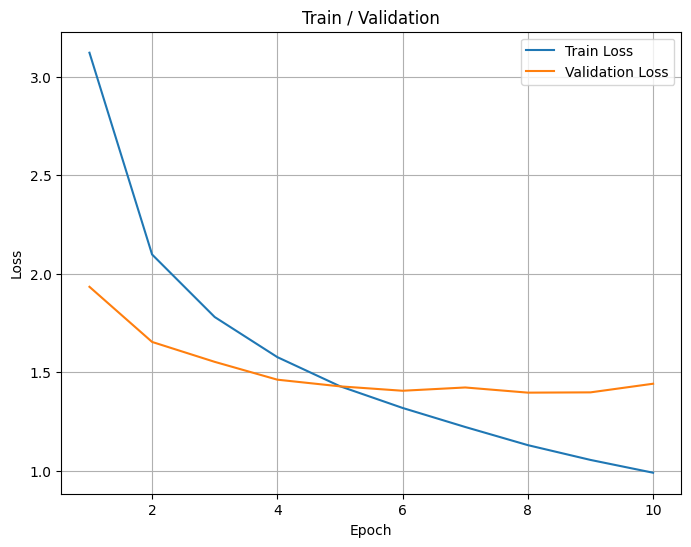

In [ ]:
loss = history.history["loss"]
val_loss = history.history["val_loss"]

plt.figure(figsize=(8, 6))
plt.plot(epochs, loss, label="Train Loss")
plt.plot(epochs, val_loss, label="Validation Loss")

plt.title("Train / Validation")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.show()
